# Exploratory Climate Analysis: Hawaii

In [1]:
# import libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# First Look @ Measurement

m_firstrow = session.query(Measurement).first()
m_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21d80d39208>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
# First Look @ Station

s_firstrow = session.query(Station).first()
s_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21d80d3ccc8>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

In [12]:
# Importing module and getting data types for measurement
from sqlalchemy import inspect

inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# .. and station

inspector = inspect(engine)
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# getting date info including year from last date

print('earliest day')
print(session.query(Measurement.date).order_by(Measurement.date).first())
print('latest day')
print(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
print('total dates')
print(session.query(func.count(Measurement.date)).all())

earliest day
('2010-01-01',)
latest day
('2017-08-23',)
total dates
[(19550,)]


In [15]:
# ...get latest day
latest_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_day = list(np.ravel(latest_day))[0]
latest_day

'2017-08-23'

In [16]:
# ..get latest day in datetime format
latest_day = dt.datetime.strptime(latest_day, '%Y-%m-%d')
latest_day

datetime.datetime(2017, 8, 23, 0, 0)

In [17]:
# .. pull out latest date into seperate Y, M, D variables

month = int(dt.datetime.strftime(latest_day, '%m'))
day = int(dt.datetime.strftime(latest_day, '%d'))
year = int(dt.datetime.strftime(latest_day, '%Y'))
print(month, day, year)

8 23 2017


In [18]:
# ...now get the year before the latest day
year_before = dt.date(year, month, day)-dt.timedelta(days=365)

In [19]:
# ... creating query to retrieve the data and precipitation scores over the last year from the latest date

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_before).\
    order_by(Measurement.date.desc()).all()

# ----- notes-----

#prcp_data = []
#for row in results:
    #print(row)
#    prcp_data.append(row)
#print(len(prcp_data))
#dates = [result[0] for result in results[:1397]]
#prcp = [result[1] for result in results[:1397]]
#x = df.groupby(['Date']).mean()
#x.plot.bar()

#prcp_data = []
    
#for result in results:
#    prcp_dictt = {result.date: result.prcp}
#    prcp_data.append(prcp_dict)
#prcp_data

In [20]:
# ...make the DF
df = pd.DataFrame(results, columns=['Date', 'Prcp'])

# ...changing string object to datetime object  
df['Date']= pd.to_datetime(df['Date'])

# ...sorting
df = df.sort_values(['Date'], ascending=True)

# ...& setting the index to the date column
df = df.set_index('Date')

# dropping null Prcp rows
df = df.dropna()

df

,Prcp
Date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,2.28
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


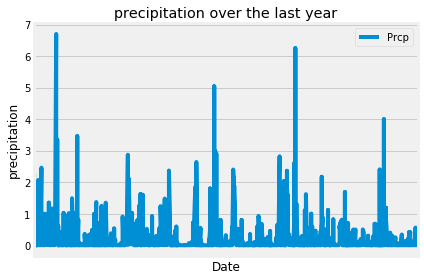

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line()
plt.xticks([])
plt.title('precipitation over the last year')
plt.ylabel('precipitation')
plt.tight_layout()
plt.show()


In [22]:
# ...summary statistics for the precipitation data
df.describe()


,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# get list of station names...

all_stations = session.query(Station.name).all()
all_stations = list(np.ravel(all_stations))
all_stations

# NOTES ...get total num of stations in data set by loopppppps
# ---------------------------------------------------------
#station_list = []
#for station in all_stations:
#    if station not in station_list:
#        station_list.append(station)
#print('____________________')
#print(f'There are {len(station_list2)} stations represented in the data set.')


['WAIKIKI 717.2, HI US',
 'KANEOHE 838.1, HI US',
 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
 'PEARL CITY, HI US',
 'UPPER WAHIAWA 874.3, HI US',
 'WAIMANALO EXPERIMENTAL FARM, HI US',
 'WAIHEE 837.5, HI US',
 'HONOLULU OBSERVATORY 702.2, HI US',
 'MANOA LYON ARBO 785.2, HI US']

In [24]:
# ... get station the station id's and number of stations

stations_count = session.query(Station).count()

stations_list = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(Measurement.station.desc()).all()

print(f'There are {stations_count} stations')
print('________________________')
stations_list

There are 9 stations
________________________


[('USC00519523'),
 ('USC00519397'),
 ('USC00519281'),
 ('USC00518838'),
 ('USC00517948'),
 ('USC00516128'),
 ('USC00514830'),
 ('USC00513117'),
 ('USC00511918')]

In [25]:
# ...list the stations & obsv counts in descending order
stations_by_obs = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

stations_by_obs

# NOTES-----------------
# ...show the most active station
#most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
#    group_by(Measurement.station).\
#    order_by(func.count(Measurement.station).desc()).first()
#print(f'The most active station is {most_active_station[0]} with {most_active_station[1]} rows of data.')

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# ... Get the the most active station
most_active = stations_by_obs[0][0]
most_active

'USC00519281'

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
    
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

print(highest_temp, lowest_temp, avg_temp)


[('USC00519281', 85.0)] [('USC00519281', 54.0)] [('USC00519281', 71.66378066378067)]


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_before).\
    filter(Measurement.station == most_active).\
    order_by(Measurement.date.desc()).all()


# NOTES-----------------
#tobs_data = []
#for row in tobs_results:
#    print(row)
#    tobs_data.append(row)

In [29]:
# ...make the DF
tobs_df = pd.DataFrame(tobs_results, columns=['Date', 'Tobs'])

# ...changing string object to datetime object  
tobs_df['Date']= pd.to_datetime(tobs_df['Date'])

# ...sorting
tobs_df = tobs_df.sort_values(['Date'], ascending=True)

# ...& setting the index to the date column
tobs_df = tobs_df.set_index('Date')

tobs_df

,Tobs
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


In [30]:
# checking for null values in columns
tobs_df.columns[tobs_df.isna().any()].tolist()

[]

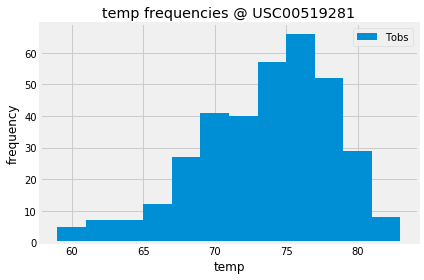

In [31]:
# ... plotting results in a histor
tobs_df.plot.hist(bins=12)
plt.title('temp frequencies @ USC00519281')
plt.ylabel('frequency')
plt.xlabel('temp')
plt.tight_layout()
plt.show()